In [ ]:
"""
VAEs can be used for generative purposes. 
This code demonstrates VAE using MNIST dataset.
Just like regular autoencoder VAE returns an array (image) of same domensions
as input but we can introduce variation by tweaking the latent vector.
"""

'\nVAEs can be used for generative purposes. \nThis code demonstrates VAE using MNIST dataset.\nJust like regular autoencoder VAE returns an array (image) of same domensions\nas input but we can introduce variation by tweaking the latent vector.\n'

In [ ]:
import keras
from keras.layers import Conv2D, Dense, Reshape, Lambda, Input, Conv2DTranspose, Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32')
x_test= x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)
x_train.shape

(60000, 28, 28, 1)

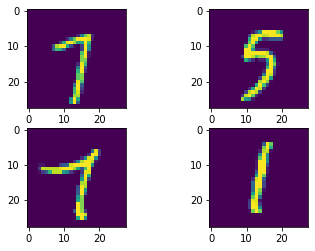

In [ ]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()

In [ ]:
# BUILD THE MODEL

# # ================= #############
# # Encoder
#Let us define 4 conv2D, flatten and then dense
# # ================= ############

latent_dim = 2 # Number of latent dim parameters

input_img = Input(input_shape, name = 'encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, (2, 2), padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3,  padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) # shape of the above output tensor

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 

z_mu = Dense(latent_dim, name = 'latent_mu')(x) #Mean values of encoded input
z_sigma = Dense(latent_dim, name = 'latent_log_sigma')(x) #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the lambda custom layer we are adding for gradient descent calculations
# using mu and variance (sigma)

z = Lambda(sample_z, output_shape = (latent_dim, ), name = 'z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.

encoder = Model(input_img, [z_mu, z_sigma, z], name = 'encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_9[0][0]                   
____________________________________________________________________________________________

In [ ]:
# ================= ###########
# Decoder
#
# ================= #################

# decoder takes the latent vector as input
decoder_input = Input(shape = (latent_dim,), name = 'decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding = 'same', activation='relu', strides = (2, 2))(x)

#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(1, 3, padding = 'same', activation='sigmoid', name = 'decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# apply the decoder to the latent sample 
z_decoded = decoder(z)


# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

# =================
# VAE 
# =================
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_9[0][0]                   
________________________________________________________________________________________________

In [ ]:
# Train autoencoder
vae.fit(x_train, None, epochs = 50, batch_size = 32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
47872/48000 [============================>.] - ETA: 0s - loss: 0.1954

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


48000/48000 [==============================] - 9s 192us/sample - loss: 0.1954 - val_loss: 0.1944
Epoch 2/50
48000/48000 [==============================] - 9s 181us/sample - loss: 0.1931 - val_loss: 0.1921
Epoch 3/50
48000/48000 [==============================] - 9s 180us/sample - loss: 0.1914 - val_loss: 0.1914
Epoch 4/50
48000/48000 [==============================] - 9s 179us/sample - loss: 0.1901 - val_loss: 0.1907
Epoch 5/50
48000/48000 [==============================] - 9s 179us/sample - loss: 0.1889 - val_loss: 0.1888
Epoch 6/50
48000/48000 [==============================] - 9s 177us/sample - loss: 0.1879 - val_loss: 0.1881
Epoch 7/50
48000/48000 [==============================] - 9s 178us/sample - loss: 0.1869 - val_loss: 0.1883
Epoch 8/50
48000/48000 [==============================] - 9s 178us/sample - loss: 0.1863 - val_loss: 0.1875
Epoch 9/50
48000/48000 [==============================] - 9s 179us/sample - loss: 0.1855 - val_loss: 0.1863
Epoch 10/50
48000/48000 [==============

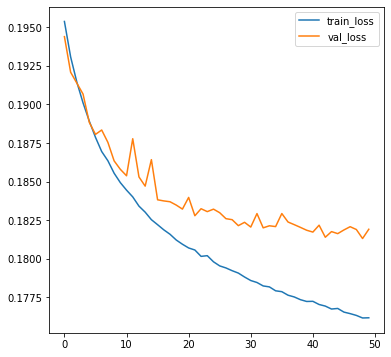

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(vae.history.history['loss'], label = 'train_loss')
plt.plot(vae.history.history['val_loss'], label = 'val_loss')
plt.legend()

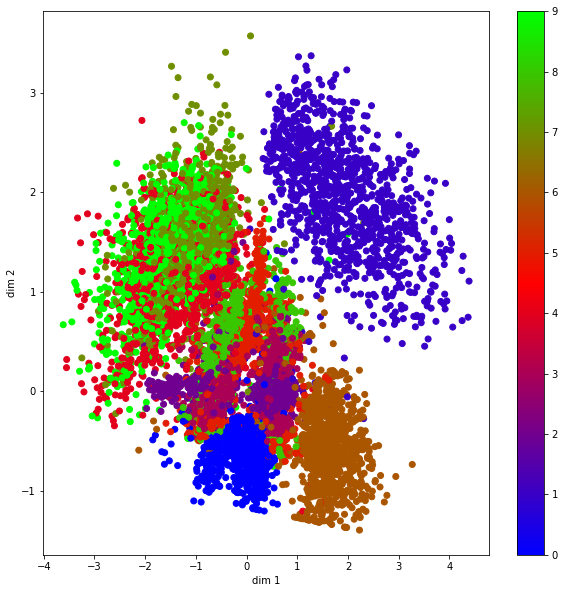

In [ ]:
# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize = (10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c = y_test, cmap = 'brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

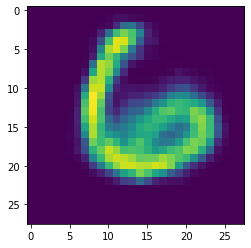

In [ ]:
# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -4 to 4 and -2 to 3 so pick random values within this range

#one image to the other.
sample_vector = np.array([[1.5,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

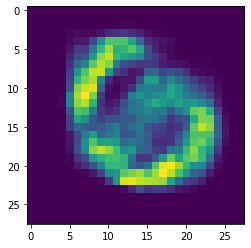

In [ ]:
sample_vector = np.array([[0.8,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

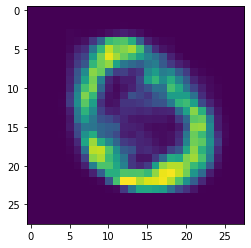

In [ ]:
sample_vector = np.array([[0.6,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

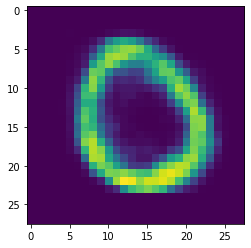

In [ ]:
sample_vector = np.array([[0.4,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

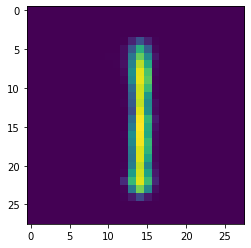

In [ ]:
sample_vector = np.array([[3,2]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

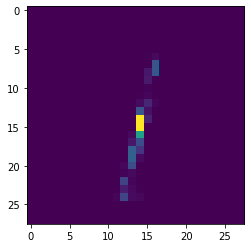

In [ ]:
sample_vector = np.array([[4,5]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28, 28)
plt.imshow(decoded_example_reshaped)

In [ ]:
img_width= img_height = 28
num_channels = 1

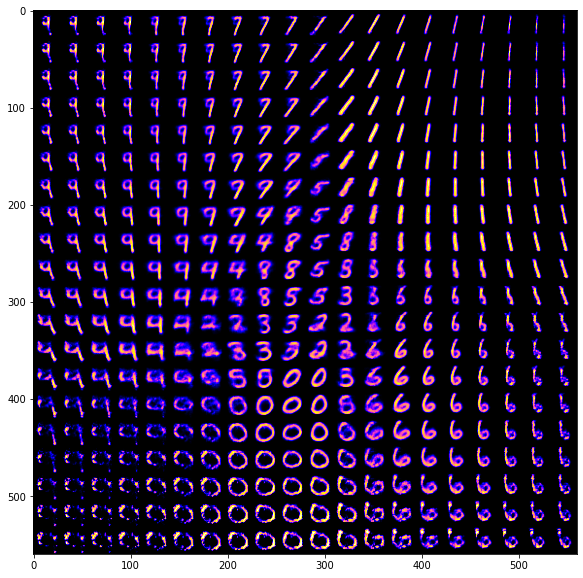

In [ ]:
#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.
n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-2, 3, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show() 

In [ ]:
encoder.save('/content/drive/MyDrive/VAE/encoder.h5')
decoder.save('/content/drive/MyDrive/VAE/decoder.h5')
vae.save('/content/drive/MyDrive/VAE/vae.h5')

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/VAE/decoder.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


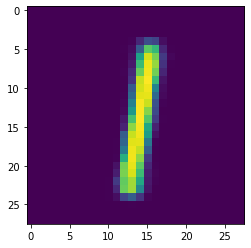

In [ ]:
inputs = np.array([[2, 2]])
pred_img = model.predict(inputs)
plt.imshow(pred_img.reshape(28, 28))

## making using keras 2.4

In [1]:
import keras
from keras.layers import Conv2D, Dense, Reshape, Lambda, Input, Conv2DTranspose, Flatten
from keras.models import Model, Sequential
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
import tensorflow as tf


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32')
x_test= x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

In [4]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)
x_train.shape

(60000, 28, 28, 1)

In [23]:
input_shape = (28,28,1)
CONV_SHAPE = (None, 14, 14, 64)

In [7]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [27]:
def get_encoder(input_shape):
  inputs = Input(input_shape)
  x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
  x = Conv2D(64, 3, (2, 2), padding='same', activation='relu')(x)
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = Conv2D(64, 3,  padding='same', activation='relu')(x)
  conv_shape = K.int_shape(x)

  x = Flatten()(x)
  x = Dense(32, activation = 'relu')(x)

  z_mu = Dense(2)(x)
  z_sigma = Dense(2)(x)

  z = Lambda(sample_z, output_shape = (2, ))([z_mu, z_sigma])

  model = Model(inputs, [z_mu, z_sigma, z])
  #model.summary()
  return model, conv_shape


In [28]:
def get_decoder(conv_shape):
  inputs = Input(shape = (2,))
  x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(inputs)
  x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
  x = Conv2DTranspose(32, 3, padding = 'same', activation='relu', strides = (2, 2))(x)
  x = Conv2DTranspose(1, 3, padding = 'same', activation='sigmoid', name = 'decoder_output')(x)

  model = Model(inputs, x)
  #model.summary()

  return model

In [43]:
def vae_model(input_shape):
  encoder, conv_shape = get_encoder(input_shape)
  decoder = get_decoder(conv_shape)

  inputs = Input(input_shape)
  z_mu, z_sigma, z = encoder(inputs)
  z_recon = decoder(z)
  z_recon = Flatten()(z_recon)
  
  outputs = keras.layers.concatenate([z_mu, z_sigma, z_recon])
  model = Model(inputs, outputs)
  model.summary()
  return model, encoder, decoder

In [44]:
vae_model(input_shape)

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model_28 (Functional)           [(None, 2), (None, 2 494244      input_32[0][0]                   
__________________________________________________________________________________________________
model_29 (Functional)           (None, 28, 28, 1)    56385       model_28[0][2]                   
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 784)          0           model_29[0][0]                   
___________________________________________________________________________________________

(<tensorflow.python.keras.engine.functional.Functional at 0x7fb5542ce6d0>,
 <tensorflow.python.keras.engine.functional.Functional at 0x7fb554300790>)

In [48]:
def loss(y_true, y_pred):
  y_true = K.flatten(y_true)

  z_mu = y_pred[:, :2]
  z_sigma = y_pred[:, 2: 4]
  z_recon = K.flatten(y_pred[:, 4 : ])

  recon_loss = keras.metrics.binary_crossentropy(y_true, z_recon)
  # KL divergence
  kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

  return K.mean(recon_loss + kl_loss)

In [49]:
vae, encoder, decoder = vae_model(input_shape)
vae.compile(loss = loss, optimizer = 'adam')

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model_34 (Functional)           [(None, 2), (None, 2 494244      input_38[0][0]                   
__________________________________________________________________________________________________
model_35 (Functional)           (None, 28, 28, 1)    56385       model_34[0][2]                   
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 784)          0           model_35[0][0]                   
___________________________________________________________________________________________

In [50]:
# Train autoencoder
vae.fit(x_train, x_train, epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
1500/1500 [==============================] - 41s 5ms/step - loss: 0.2940 - val_loss: 0.2181
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2125 - val_loss: 0.2027
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2018 - val_loss: 0.1970
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1963 - val_loss: 0.1945
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1926 - val_loss: 0.1916
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1906 - val_loss: 0.1897
Epoch 7/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1891 - val_loss: 0.1884
Epoch 8/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1872 - val_loss: 0.1874
Epoch 9/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1864 - val_loss: 0.1870
Epoch 10/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.18

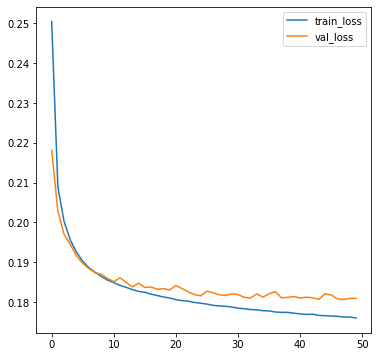

In [51]:
plt.figure(figsize=(6, 6))
plt.plot(vae.history.history['loss'], label = 'train_loss')
plt.plot(vae.history.history['val_loss'], label = 'val_loss')
plt.legend()

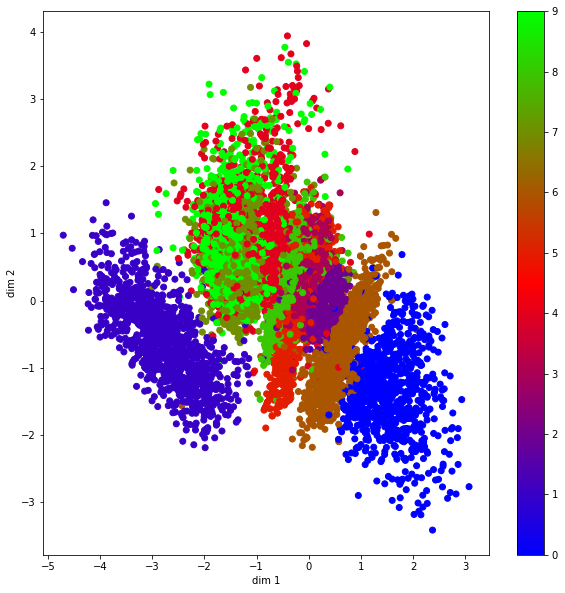

In [52]:
# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize = (10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c = y_test, cmap = 'brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

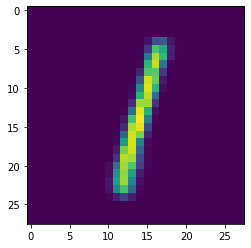

In [60]:
inputs = np.array([[-3, -1]])
pred_img = decoder.predict(inputs)
plt.imshow(pred_img.reshape(28, 28))

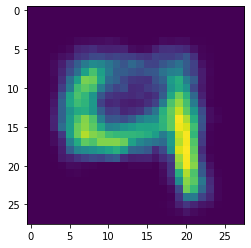

In [86]:
inputs = np.array([[0, 3]])
pred_img = decoder.predict(inputs)
plt.imshow(pred_img.reshape(28, 28))

In [56]:
img_height = img_width = 28
num_channels = 1

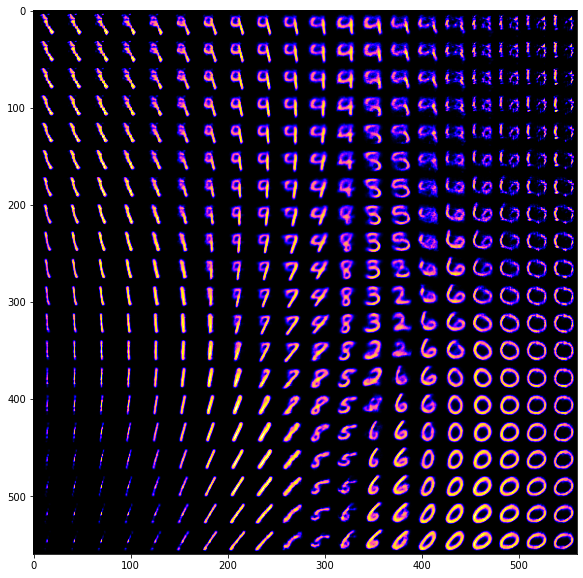

In [59]:
#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.
n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 3, n)
grid_y = np.linspace(-2, 3, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show() 